In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
import numpy as np

In [2]:
# Importando o dataset
df_mkt = pd.read_csv('./dados/mkt.csv')
df_mkt.describe()

,instagram,facebook,blog,vendas
count,171.000000,171.000000,171.000000,171.000000
mean,178.021053,27.671579,35.240000,16.922807
std,102.449597,17.913532,24.902918,6.314608
min,0.840000,0.000000,0.360000,1.920000
25%,91.080000,11.700000,13.740000,12.540000
50%,179.760000,26.760000,31.080000,15.480000
75%,262.980000,43.680000,50.880000,20.820000
max,355.680000,59.520000,121.080000,32.400000


                            OLS Regression Results                            
Dep. Variable:                 vendas   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     431.7
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           5.13e-68
Time:                        15:51:27   Log-Likelihood:                -279.36
No. Observations:                 136   AIC:                             566.7
Df Residuals:                     132   BIC:                             578.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7030      0.427      8.675      0.0

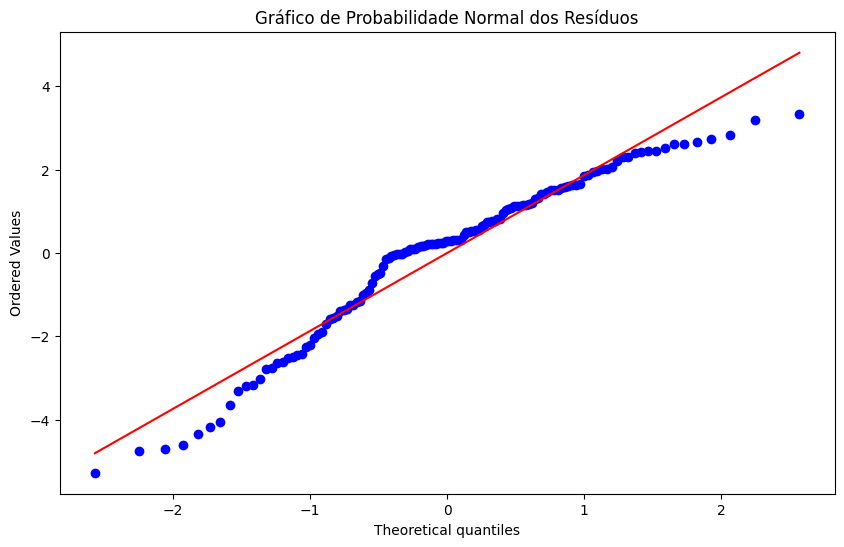

Fatores de Inflação da Variância (VIF):
    Variavel       VIF
0  instagram  2.679924
1   facebook  3.069419
2       blog  2.954567

----- Teste de Durbin-Watson -----
Valor de Durbin-Watson: 1.69
Teste de Breusch-Pagan:
Estatística de teste: 4.2203, p-valor: 0.2386


In [83]:
'''
# GRAFICOS DE CORRELAÇÃO
plt.figure(figsize=(10, 8))
corr_matrix = df_mkt.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

# GERANDO O GRÁFICO DE DISTRIBUIÇÃO DE CADA COLUNA
plt.figure(figsize=(15, 10))

for i , coluna in enumerate(df_mkt.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_mkt[coluna], kde=True)
    plt.title(f'Distribuiição de {coluna}')
plt.tight_layout()
plt.show()   

'''

# DEFININDO OS X E Y
x = df_mkt.drop(columns='vendas')
y = df_mkt['vendas']


# DIVIDINDO OS DADOS EM TREINO E TESTE
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.2, random_state=42)

# TREINANDO O MODELO
x_treino_sm = sm.add_constant(x_treino)
modelo_stats = sm.OLS(y_treino, x_treino_sm).fit()
print(modelo_stats.summary())


# Treinando Linear Regression
mod_lr = LinearRegression().fit(x_treino, y_treino)
y_pred = mod_lr.predict(x_teste)

print("\nR² no conjunto de teste:", round(r2_score(y_teste, y_pred), 2))


# Linearidade
residuais = modelo_stats.resid
preditos = modelo_stats.fittedvalues
'''
# Plotando os dados
plt.figure(figsize=(9, 6))
sns.scatterplot(x=preditos, y=residuais)
plt.axhline(y=0, color='red', linestyle='--')

plt.title('Resíduos vs Preditos')
plt.xlabel('Preditos values')
plt.ylabel('Resíduos')
plt.show()
'''
# NORMALIDADE DOS RESÍDUOS
plt.figure(figsize=(10, 6))
stats.probplot(residuais, dist="norm", plot=plt)
plt.title("Gráfico de Probabilidade Normal dos Resíduos")
plt.show()



# MULTICOLINEARIDADE (VIF)
vif_data = pd.DataFrame()
vif_data['Variavel'] = x_treino_sm.drop(columns='const').columns
vif_data['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

# RESULTADO
print('Fatores de Inflação da Variância (VIF):')
print(vif_data)

# INDEPENDECIA DOS ERROS (DURBIN-WATSON)

durbin_watson = sm.stats.durbin_watson(residuais)

print('\n----- Teste de Durbin-Watson -----')
print(f'Valor de Durbin-Watson: {durbin_watson:.2f}')

# HOMOSCEDASTICIDADE (BREUCH-PAGAN)

brp_teste = sm.stats.diagnostic.het_breuschpagan(residuais, modelo_stats.model.exog)

# RESULTADO

print('Teste de Breusch-Pagan:')
print(f'Estatística de teste: {brp_teste[0]:.4f}, p-valor: {brp_teste[1]:.4f}')




In [84]:
# Dados do modelo (substitua pelos valores reais do seu modelo)
r2 = r2_score(y_teste, y_pred)  # R² ajustado
vif_max = vif_data['VIF'].max()
bp_pvalue = brp_teste[1]  # p-value do teste Breusch-Pagan
significancia_variaveis = all(p < 0.05 for p in modelo_stats.pvalues[1:])  # Verifica se todas as variáveis são significativas

# Avaliação da robustez do modelo
print("\n=== RELATÓRIO DE ROBUSTEZ DO MODELO ===")

# 1. Avaliação do Poder Explicativo (R²)
if r2 >= 0.8:
    print("\n1. Poder Explicativo: EXCELENTE (R² ajustado = {:.2f})".format(r2))
    print("   → O modelo explica mais de 80% da variabilidade nas vendas.")
elif r2 >= 0.6:
    print("\n1. Poder Explicativo: BOM (R² ajustado = {:.2f})".format(r2))
    print("   → O modelo explica uma porção significativa da variabilidade, mas há espaço para melhorias.")
else:
    print("\n1. Poder Explicativo: FRACO (R² ajustado = {:.2f})".format(r2))
    print("   → O modelo precisa ser melhorado para ser útil na prática.")

# 2. Avaliação da Multicolinearidade (VIF)
if vif_max < 5:
    print("\n2. Multicolinearidade: ACEITÁVEL (VIF máximo = {:.2f})".format(vif_max))
    print("   → Não há problemas significativos de correlação entre as variáveis preditoras.")
elif vif_max < 10:
    print("\n2. Multicolinearidade: MODERADA (VIF máximo = {:.2f})".format(vif_max))
    print("   → Alguma multicolinearidade presente, mas pode ser tolerável.")
else:
    print("\n2. Multicolinearidade: GRAVE (VIF máximo = {:.2f})".format(vif_max))
    print("   → Problemas sérios de multicolinearidade que prejudicam o modelo.")

# 3. Avaliação da Normalidade dos Resíduos (Durbin-Watson)
if 1.5 < durbin_watson < 2.5:
    print("\n3. Autocorrelação dos Resíduos: ACEITÁVEL (durbin_watson = {:.2f})".format(durbin_watson))
    print("   → Não há evidência forte de autocorrelação nos resíduos.")
else:
    print("\n3. Autocorrelação dos Resíduos: PROBLEMÁTICA (durbin_watson = {:.2f})".format(durbin_watson))
    print("   → Possível autocorrelação nos resíduos que viola os pressupostos do modelo.")

# 4. Avaliação da Homocedasticidade (Breusch-Pagan)
if bp_pvalue > 0.05:
    print("\n4. Homocedasticidade: ACEITÁVEL (p-value = {:.4f})".format(bp_pvalue))
    print("   → A variância dos resíduos é constante (homocedasticidade).")
else:
    print("\n4. Homocedasticidade: PROBLEMÁTICA (p-value = {:.4f})".format(bp_pvalue))
    print("   → Evidência de heterocedasticidade (variância não constante dos resíduos).")

# 5. Significância das Variáveis
if significancia_variaveis:
    print("\n5. Significância das Variáveis: TODAS SIGNIFICATIVAS")
    print("   → Todas as variáveis preditoras contribuem significativamente para o modelo.")
else:
    print("\n5. Significância das Variáveis: ALGUMAS NÃO SIGNIFICATIVAS")
    print("   → Algumas variáveis podem não estar contribuindo significativamente.")

# Conclusão Final
print("\n=== CONCLUSÃO FINAL ===")

condicoes_ideais = (r2 >= 0.7 and vif_max < 5 and 1.5 < durbin_watson < 2.5 and bp_pvalue > 0.05 and significancia_variaveis)

if condicoes_ideais:
    print("✅ MODELO ROBUSTO: Atende a todos os critérios de qualidade.")
    print("   Pode ser usado com confiança para previsão e tomada de decisão.")
elif (r2 >= 0.6 and vif_max < 10):
    print("⚠️ MODELO RAZOÁVEL: Tem limitações, mas pode ser útil com ressalvas.")
    print("   Recomendamos melhorias antes de uso em decisões críticas.")
else:
    print("❌ MODELO FRACO: Problemas significativos encontrados.")
    print("   Não recomendado para tomada de decisão sem melhorias substanciais.")

# Recomendações específicas
print("\n=== RECOMENDAÇÕES ===")
if bp_pvalue <= 0.05:
    print("- Considere transformações nas variáveis (ex: log) para tratar heterocedasticidade")
if not significancia_variaveis:
    print("- Reavalie as variáveis não significativas para possível remoção")
if vif_max >= 5:
    print("- Investigue possíveis colinearidades entre as variáveis preditoras")

print("\nRelatório concluído. Considere sempre o contexto do negócio na interpretação.")



=== RELATÓRIO DE ROBUSTEZ DO MODELO ===

1. Poder Explicativo: EXCELENTE (R² ajustado = 0.87)
   → O modelo explica mais de 80% da variabilidade nas vendas.

2. Multicolinearidade: ACEITÁVEL (VIF máximo = 3.07)
   → Não há problemas significativos de correlação entre as variáveis preditoras.

3. Autocorrelação dos Resíduos: ACEITÁVEL (durbin_watson = 1.69)
   → Não há evidência forte de autocorrelação nos resíduos.

4. Homocedasticidade: ACEITÁVEL (p-value = 0.2386)
   → A variância dos resíduos é constante (homocedasticidade).

5. Significância das Variáveis: ALGUMAS NÃO SIGNIFICATIVAS
   → Algumas variáveis podem não estar contribuindo significativamente.

=== CONCLUSÃO FINAL ===
⚠️ MODELO RAZOÁVEL: Tem limitações, mas pode ser útil com ressalvas.
   Recomendamos melhorias antes de uso em decisões críticas.

=== RECOMENDAÇÕES ===
- Reavalie as variáveis não significativas para possível remoção

Relatório concluído. Considere sempre o contexto do negócio na interpretação.
